<h1>Prediction Models After Handling Outliers</h1>

In [731]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.pyplot import scatter
from openpyxl.utils.datetime import to_excel
from pandas import isnull
from seaborn import barplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score


pd.set_option('display.max_rows', 200)
pd.options.mode.copy_on_write = True
df_house_price = pd.read_csv(r'C:\Users\Sajin Siyad\Desktop\Ireland House Price Final.csv')

#checking for duplicates
df = df_house_price.duplicated()
df.unique() # found no duplicates

array([False])

In [732]:
df_house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    13320 non-null  int64  
 1   property_scope        13320 non-null  object 
 2   availability          13320 non-null  object 
 3   location              13319 non-null  object 
 4   size                  13304 non-null  object 
 5   total_sqft            13320 non-null  object 
 6   bath                  13247 non-null  float64
 7   balcony               12711 non-null  float64
 8   buying or not buying  13320 non-null  object 
 9   BER                   13320 non-null  object 
 10  Renovation needed     13320 non-null  object 
 11  price-per-sqft-$      13074 non-null  float64
dtypes: float64(3), int64(1), object(8)
memory usage: 1.2+ MB


In [733]:
df_house_price['price-per-sqft-$'] = df_house_price['price-per-sqft-$'].apply(lambda x: round(x, 2))
df_house_price = df_house_price.rename(columns={'price-per-sqft-$': 'price_per_squarefeet ($)'})
df_house_price = df_house_price.rename(columns={'buying or not buying': 'buying_decision'})

In [734]:
# Cleaning total square feet
def clean_text(text):
    text = str(text)
    if '-' in text:
        temp = text.split('-')
        temp = [float(value.strip()) for value in temp]
        text = sum(temp)/2   
    if isinstance(text, str) and 'Sq. Meter' in text:
        text = text.replace('Sq. Meter', '').strip()  # Remove 'sq. meter' and strip spaces
        return round(float(text) * 10.7639, 2)  # Convert sq. meter to sq. feet (1 square meter (Sq. Meter) = 10.7639 square feet)
    elif isinstance(text, str) and 'Sq. Yards' in text:
        text = text.replace('Sq. Yards', '').strip()  # Remove 'sq. yard' and strip spaces
        return round(float(text) * 9, 2) # Convert Sq. Yard to Sq. feet  (1 square yard (Sq. Yard) = 9 square feet)
    elif isinstance(text, str) and 'Acres' in text:
        text = text.replace('Acres', '').strip()
        return round(float(text) * 43560, 2)  # Convert Acres to Sq. Feet (1 acre = 43560 square feet)
    elif isinstance(text, str) and 'Cents' in text:
        text = float(text.replace('Cents', '').strip())
        return round(float(text) * 435.6, 2)  # Convert Cents to Sq. Feet (1 cent = 435.6 square feet)
    else:
        return round(float(text), 2)  # Return the numeric value if no conversion needed
        

# to drop rows with ground and guntha in the values.
df_house_price = df_house_price[~df_house_price['total_sqft'].str.contains('ground|guntha|perch', case=False, na=False)]
df_house_price['total_sqft'] = df_house_price['total_sqft'].apply(clean_text)
df_house_price = df_house_price.rename(columns={'total_sqft': 'total_squarefeet'})
df_house_price

,ID,property_scope,availability,location,size,total_squarefeet,bath,balcony,buying_decision,BER,Renovation needed,price_per_squarefeet ($)
0,0,Extended Coverage,17-Oct,Fingal,2 BED,1056.0,2.0,1.0,No,A,No,419.93
1,1,Land Parcel,Ready To Move,South Dublin,4 Bedroom,2600.0,5.0,3.0,No,D,Yes,523.85
2,2,Constructed Space,Ready To Move,Dun Laoghaire,3 BED,1440.0,2.0,3.0,No,G,Yes,488.68
3,3,Extended Coverage,Ready To Move,South Dublin,3 BED,1521.0,3.0,1.0,No,G,Yes,708.91
4,4,Extended Coverage,Ready To Move,DCC,2 BED,1200.0,2.0,1.0,No,F,Yes,482.38
...,...,...,...,...,...,...,...,...,...,...,...,...
13315,13315,Constructed Space,Ready To Move,Dun Laoghaire,5 Bedroom,3453.0,4.0,0.0,Yes,B,Maybe,759.30
13316,13316,Extended Coverage,Ready To Move,Fingal,4 BED,3600.0,5.0,NaN,No,A,No,1261.11
13317,13317,Constructed Space,Ready To Move,Fingal,2 BED,1141.0,2.0,1.0,No,A,No,596.84
13318,13318,Extended Coverage,18-Jun,South Dublin,4 BED,4689.0,4.0,1.0,No,C,Maybe,1181.23


In [735]:
# changing the dates in the availability column to future availability
def categorize_availability(date):
    if date == "Ready To Move":
        return "Ready To Move"

    elif date == "Immediate Possession":
        return "Immediate Possession"
    else:
        return "Future Availability"


# Apply the function to the availability column
df_house_price['availability'] = df_house_price['availability'].apply(categorize_availability)
# change the column name size to bedroom
df_house_price = df_house_price.rename(columns={'size': 'bedroom'})
# Remove the word "Bedroom" from the 'size' column
# df['bedroom'] = df['bedroom'].str.replace(' Bedroom', '', regex=False)
df_house_price['bedroom'] = df_house_price['bedroom'].str.extract(r'(\d+)').astype(float)

# Drop rows with null values in the 'location' column
df_house_price = df_house_price.dropna(subset=['location'])

# null_counts = df.isnull().sum()
#
# # Display columns with null values
# print(null_counts[null_counts > 0])
df_house_price.isna().sum()

ID                            0
property_scope                0
availability                  0
location                      0
bedroom                      16
total_squarefeet              0
bath                         73
balcony                     608
buying_decision               0
BER                           0
Renovation needed             0
price_per_squarefeet ($)    242
dtype: int64

### Imputing Missing Values for bath, balcony, price of squarefeet

In [737]:
# median of bedroom
medianof_bedroom = df_house_price['bedroom'].median()
# median of bath
medianof_bath = df_house_price['bath'].median()
# median of balcony
medianof_balcony = df_house_price['balcony'].median()

# Fill missing values in 'bedroom' with its median
df_house_price['bedroom'] = df_house_price['bedroom'].fillna(round(medianof_bedroom))
# Fill missing values in 'balcony' with its median
df_house_price['balcony'] = df_house_price['balcony'].fillna(round(medianof_balcony))
# Fill missing values in 'bath' column with its median
df_house_price['bath'] = df_house_price['bath'].fillna(round(medianof_bath))

# First, fill NaN values based on the most granular grouping
df_house_price['price_per_squarefeet ($)'] = df_house_price.groupby(['property_scope', 'location', 'bedroom'])['price_per_squarefeet ($)'].transform(lambda x: x.fillna(round(x.median(), 2)) if x.notna().any() else x)
# Second, handle remaining NaN values at a broader grouping level
df_house_price['price_per_squarefeet ($)'] = df_house_price.groupby(['property_scope', 'location'])['price_per_squarefeet ($)'].transform(lambda x: x.fillna(round(x.median(), 2)) if x.notna().any() else x)
# Third, if any NaN values are still present, assign a global fallback (e.g., 0 or overall median)
df_overall_median = round(df_house_price['price_per_squarefeet ($)'].median(), 2)
df_house_price['price_per_squarefeet ($)'] = df_house_price['price_per_squarefeet ($)'].fillna(df_overall_median)


df_house_price.isna().sum()

ID                          0
property_scope              0
availability                0
location                    0
bedroom                     0
total_squarefeet            0
bath                        0
balcony                     0
buying_decision             0
BER                         0
Renovation needed           0
price_per_squarefeet ($)    0
dtype: int64

In [738]:
df_house_price.drop('ID', axis = 1, inplace = True)
df_house_price.describe()

,bedroom,total_squarefeet,bath,balcony,price_per_squarefeet ($)
count,13315.000000,1.331500e+04,13315.000000,13315.000000,1.331500e+04
mean,2.803605,1.822601e+03,2.688321,1.603455,1.415381e+03
std,1.293012,1.428388e+04,1.337417,0.803059,4.569528e+04
min,1.000000,1.000000e+00,1.000000,0.000000,3.040000e+01
25%,2.000000,1.100000e+03,2.000000,1.000000,4.862700e+02
50%,3.000000,1.277000e+03,2.000000,2.000000,6.194200e+02
75%,3.000000,1.680000e+03,3.000000,2.000000,8.326300e+02
max,43.000000,1.306800e+06,40.000000,3.000000,4.953333e+06


<h3>EDA

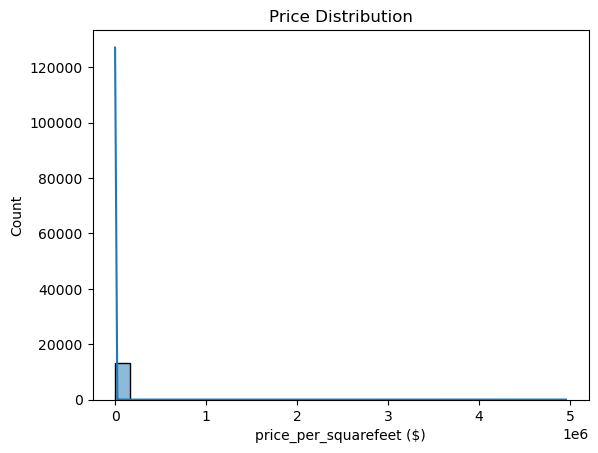

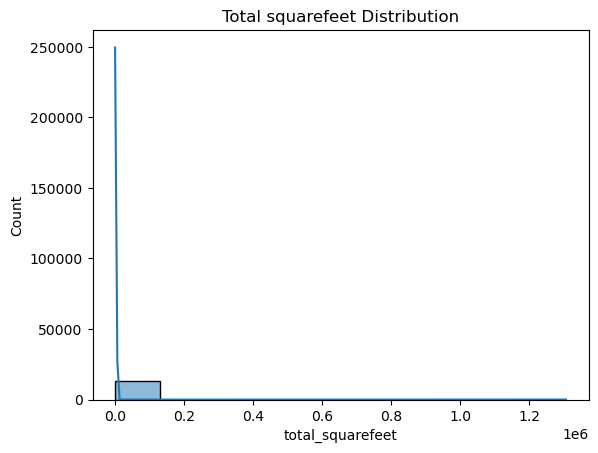

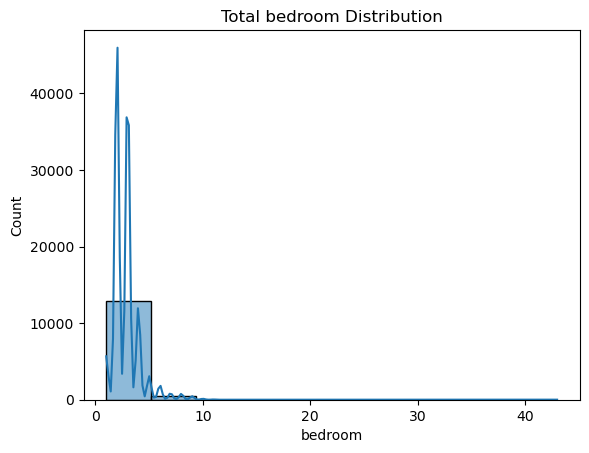

In [740]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
sns.histplot(df_house_price['price_per_squarefeet ($)'], bins=30, kde=True)
plt.title('Price Distribution')
plt.show()

# Histogram
sns.histplot(df_house_price['total_squarefeet'], bins=10, kde=True)
plt.title('Total squarefeet Distribution')
plt.show()

# Histogram
sns.histplot(df_house_price['bedroom'], bins=10, kde=True)
plt.title('Total bedroom Distribution')
plt.show()



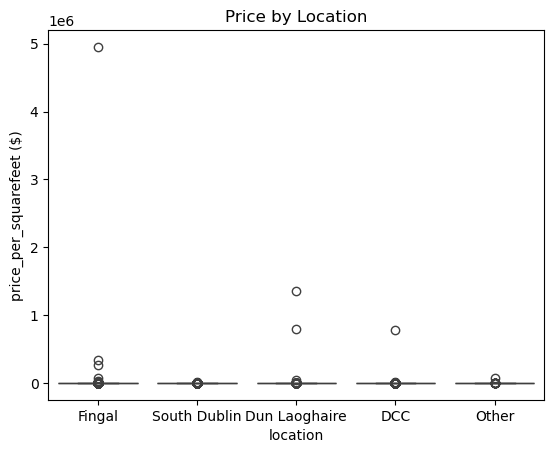

In [741]:
# Box plot
sns.boxplot(x='location', y='price_per_squarefeet ($)', data=df_house_price)
plt.title('Price by Location')
plt.show()


<h3>Adding Calculated Columns</h3>

In [743]:
# Total_Price ($) 
df_house_price['total_price ($)'] = df_house_price['price_per_squarefeet ($)'] * df_house_price['total_squarefeet']
df_house_price['price_per_bedroom ($)'] = round(df_house_price['total_price ($)'] / df_house_price['bedroom'], 2)

df_house_price.head(20)

,property_scope,availability,location,bedroom,total_squarefeet,bath,balcony,buying_decision,BER,Renovation needed,price_per_squarefeet ($),total_price ($),price_per_bedroom ($)
0,Extended Coverage,Future Availability,Fingal,2.0,1056.0,2.0,1.0,No,A,No,419.93,4.434461e+05,2.217230e+05
1,Land Parcel,Ready To Move,South Dublin,4.0,2600.0,5.0,3.0,No,D,Yes,523.85,1.362010e+06,3.405025e+05
2,Constructed Space,Ready To Move,Dun Laoghaire,3.0,1440.0,2.0,3.0,No,G,Yes,488.68,7.036992e+05,2.345664e+05
3,Extended Coverage,Ready To Move,South Dublin,3.0,1521.0,3.0,1.0,No,G,Yes,708.91,1.078252e+06,3.594174e+05
4,Extended Coverage,Ready To Move,DCC,2.0,1200.0,2.0,1.0,No,F,Yes,482.38,5.788560e+05,2.894280e+05
5,Extended Coverage,Ready To Move,Dun Laoghaire,2.0,1170.0,2.0,1.0,Yes,G,Yes,368.63,4.312971e+05,2.156485e+05
6,Extended Coverage,Future Availability,Fingal,4.0,2732.0,4.0,2.0,No,A,No,847.51,2.315397e+06,5.788493e+05
7,Extended Coverage,Ready To Move,Fingal,4.0,3300.0,4.0,2.0,No,F,Yes,2063.64,6.810012e+06,1.702503e+06
8,Extended Coverage,Ready To Move,Fingal,3.0,1310.0,3.0,1.0,No,A,No,548.01,7.178931e+05,2.392977e+05
9,Land Parcel,Ready To Move,Fingal,6.0,1020.0,6.0,2.0,Yes,C,Maybe,4117.16,4.199503e+06,6.999172e+05


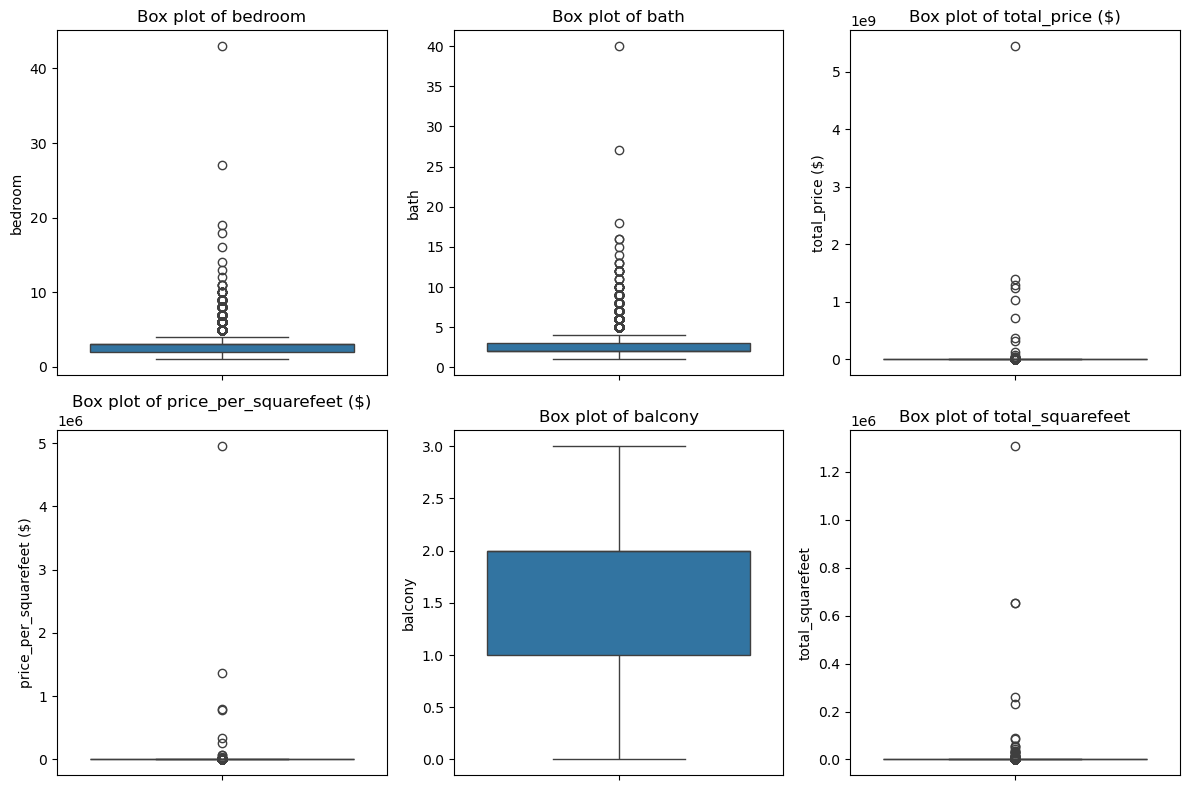

In [744]:
# examined the bath,balcony,bedroom with box plot to analyse the outliers

columns = {'bedroom', 'bath', 'balcony', 'price_per_squarefeet ($)', 'total_squarefeet', 'total_price ($)'}

plt.figure(figsize = (12,8))
for i, column in enumerate(columns,1):
    plt.subplot(2,3,i)
    sns.boxplot (y=df_house_price[column])
    plt.title(f'Box plot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### Handling Outliers

In [746]:
# Identify and exclude outliers using IQR
Q1 = df_house_price[['bedroom', 'bath', 'total_squarefeet', 'price_per_squarefeet ($)', 'total_price ($)']].quantile(0.25)
Q3 = df_house_price[['bedroom', 'bath', 'total_squarefeet', 'price_per_squarefeet ($)', 'total_price ($)']].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for non-outlier range for bath
lower_bound_bath = Q1['bath'] - 1.5 * IQR['bath']
upper_bound_bath = Q3['bath'] + 1.5 * IQR['bath']


# Define lower and upper bounds for non-outlier range for Price_per_squarefeet ($)
lower_bound_Price_per_squarefeet = Q1['price_per_squarefeet ($)'] - 1.5 * IQR['price_per_squarefeet ($)']
upper_bound_Price_per_squarefeet = Q3['price_per_squarefeet ($)'] + 1.5 * IQR['price_per_squarefeet ($)']

# Define lower and upper bounds for non-outlier range for Bedroom
lower_bound_Bedroom = Q1['bedroom'] - 1.5 * IQR['bedroom']
upper_bound_Bedroom = Q3['bedroom'] + 1.5 * IQR['bedroom']

# Define lower and upper bounds for non-outlier range for total_squarefeet
lower_bound_total_squarefeet = Q1['total_squarefeet'] - 1.5 * IQR['total_squarefeet']
upper_bound_total_squarefeet = Q3['total_squarefeet'] + 1.5 * IQR['total_squarefeet']


# Define lower and upper bounds for non-outlier range for total_price ($)
lower_bound_total_price = Q1['total_price ($)'] - 1.5 * IQR['total_price ($)']
upper_bound_total_price = Q3['total_price ($)'] + 1.5 * IQR['total_price ($)']

#Create a filter for non-outliers in both columns
non_outlier_filter = (
    (df_house_price['bath'] >= lower_bound_bath) & (df_house_price['bath'] <= upper_bound_bath) &
    (df_house_price['price_per_squarefeet ($)'] >= lower_bound_Price_per_squarefeet) & (df_house_price['price_per_squarefeet ($)'] <= upper_bound_Price_per_squarefeet) &
    (df_house_price['bedroom'] >= lower_bound_Bedroom) & (df_house_price['bedroom'] <= upper_bound_Bedroom) &
    (df_house_price['total_squarefeet'] >= lower_bound_total_squarefeet) & (df_house_price['total_squarefeet'] <= upper_bound_total_squarefeet) &
    (df_house_price['total_price ($)'] >= lower_bound_total_price) & (df_house_price['total_price ($)'] <= upper_bound_total_price)
)

# Apply the filter to drop outliers
df_house_price_cleaned = df_house_price[non_outlier_filter]
# Optionally, reset the index of the cleaned DataFrame
df_house_price_cleaned.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
# df_house_price_cleaned

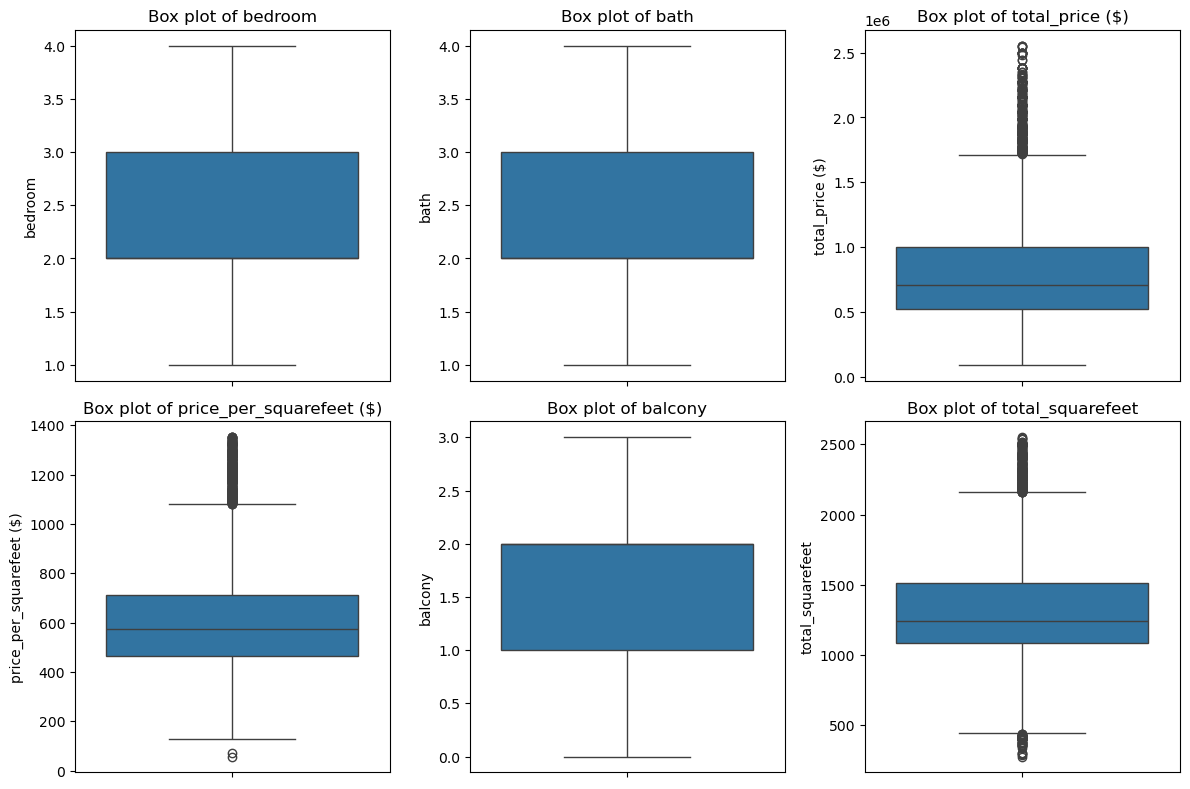

In [747]:
# box plot after removing outliers

columns = {'bedroom', 'bath', 'balcony', 'price_per_squarefeet ($)', 'total_squarefeet', 'total_price ($)'}

plt.figure(figsize = (12,8))
for i, column in enumerate(columns,1):
    plt.subplot(2,3,i)
    sns.boxplot (y=df_house_price_cleaned[column])
    plt.title(f'Box plot of {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [748]:
df_house_price_cleaned.describe()

,bedroom,total_squarefeet,bath,balcony,price_per_squarefeet ($),total_price ($),price_per_bedroom ($)
count,10737.000000,10737.000000,10737.000000,10737.000000,10737.000000,1.073700e+04,1.073700e+04
mean,2.418366,1304.111959,2.273726,1.567756,608.510279,8.108031e+05,3.361141e+05
std,0.653768,375.794334,0.643704,0.771546,198.937036,4.041129e+05,1.399420e+05
min,1.000000,276.000000,1.000000,0.000000,56.750000,9.080048e+04,3.193200e+04
25%,2.000000,1082.000000,2.000000,1.000000,465.100000,5.220988e+05,2.383520e+05
50%,2.000000,1239.000000,2.000000,2.000000,572.130000,7.082375e+05,3.121240e+05
75%,3.000000,1513.000000,3.000000,2.000000,711.850000,9.988026e+05,4.085988e+05
max,4.000000,2550.000000,4.000000,3.000000,1351.190000,2.553757e+06,2.270000e+06


<h3>Correlation</h3>

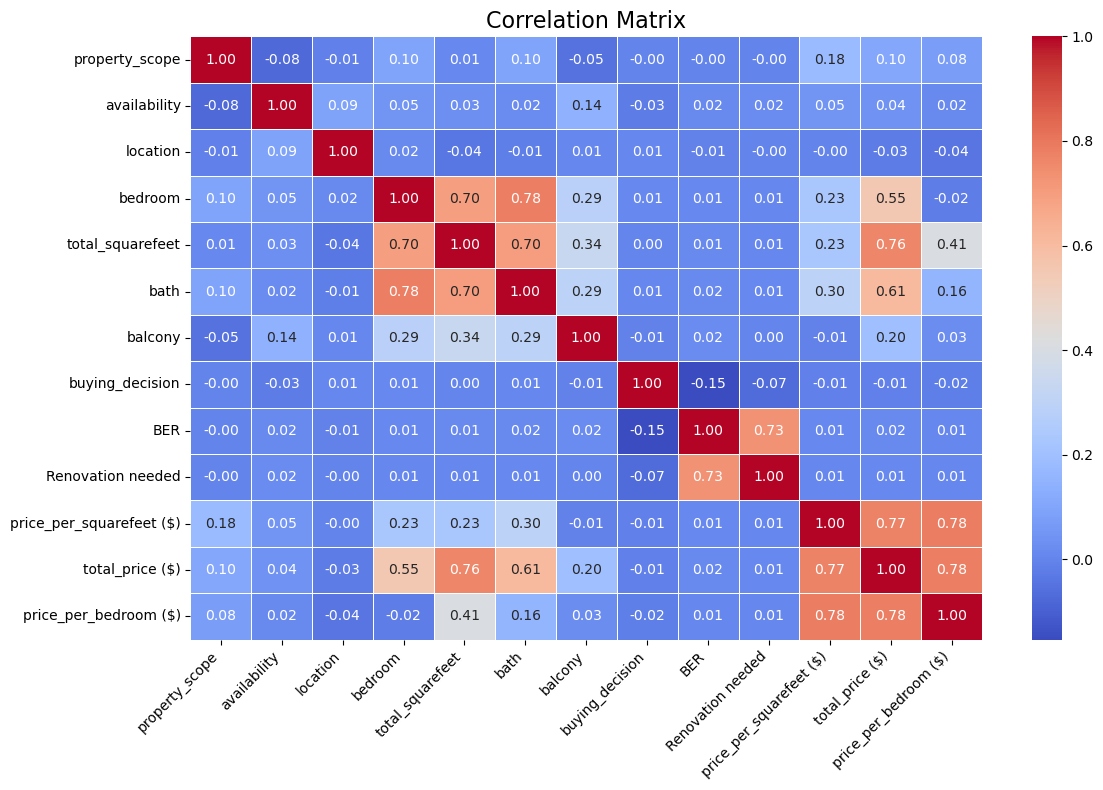

In [752]:
encoded_data = df_house_price_cleaned.copy()
for column in df_house_price_cleaned.select_dtypes(include=['object']).columns:
    encoded_data[column] = df_house_price_cleaned[column].astype('category').cat.codes

# Compute the correlation matrix
correlation_matrix = encoded_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Predictive Model Testing
<h4> Encoding</h4>

In [754]:
# Identify categorical columns
categorical_columns = df_house_price_cleaned.select_dtypes(include=['object']).columns

# Encode categorical columns using Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_house_price_cleaned[col] = le.fit_transform(df_house_price_cleaned[col])
    label_encoders[col] = le  # Save the encoder for future use

# df_house_price_cleaned['balcony'] = df_house_price_cleaned['balcony'].apply(lambda x: 1 if x > 0 else 0)

print("Encoded Dataset:")
df_house_price_cleaned.head()

Encoded Dataset:


,property_scope,availability,location,bedroom,total_squarefeet,bath,balcony,buying_decision,BER,Renovation needed,price_per_squarefeet ($),total_price ($),price_per_bedroom ($)
0,1,0,2,2.0,1056.0,2.0,1.0,0,0,1,419.93,443446.08,221723.04
1,0,2,1,3.0,1440.0,2.0,3.0,0,6,2,488.68,703699.20,234566.40
2,1,2,4,3.0,1521.0,3.0,1.0,0,6,2,708.91,1078252.11,359417.37
3,1,2,0,2.0,1200.0,2.0,1.0,0,5,2,482.38,578856.00,289428.00
4,1,2,1,2.0,1170.0,2.0,1.0,1,6,2,368.63,431297.10,215648.55


<h3> Logistic Regression</h3>

In [756]:
# Define the features (X) and target (y)
X = df_house_price_cleaned.drop(columns=['buying_decision'])  # Drop the target variable
y = df_house_price_cleaned['buying_decision']  # Target variable

# Encode the target variable if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (optional but recommended for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)  # max_iter to ensure convergence
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", lr_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
# Feature Importance 
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]  # Coefficients for logistic regression
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances (Logistic Regression Coefficients):")
print(feature_importances)

Accuracy: 0.6866852886405959

Classification Report:
              precision    recall  f1-score   support

           0       0.69      1.00      0.81      1462
           1       0.74      0.03      0.06       686

    accuracy                           0.69      2148
   macro avg       0.71      0.51      0.43      2148
weighted avg       0.70      0.69      0.57      2148


Feature Importances (Logistic Regression Coefficients):
                     Feature  Importance
8          Renovation needed    0.205282
9   price_per_squarefeet ($)    0.166714
4           total_squarefeet    0.162443
5                       bath    0.034050
2                   location    0.013721
3                    bedroom    0.009782
11     price_per_bedroom ($)   -0.016035
6                    balcony   -0.016386
0             property_scope   -0.023534
1               availability   -0.051461
10           total_price ($)   -0.272346
7                        BER   -0.483247


<h3>Random Forest Model</h3>

In [758]:
# Define the features (X) and target (y)
X = df_house_price_cleaned.drop(columns=['buying_decision'])
y = df_house_price_cleaned['buying_decision']  # Target variable

# Encode the target variable if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)  # Use 100 trees in the forest
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance 
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Accuracy: 0.7239292364990689

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      1462
           1       0.64      0.31      0.41       686

    accuracy                           0.72      2148
   macro avg       0.69      0.61      0.62      2148
weighted avg       0.71      0.72      0.69      2148


Feature Importances:
                     Feature  Importance
9   price_per_squarefeet ($)    0.166599
10           total_price ($)    0.161261
11     price_per_bedroom ($)    0.160959
4           total_squarefeet    0.150745
2                   location    0.120965
7                        BER    0.090545
6                    balcony    0.042927
0             property_scope    0.027564
8          Renovation needed    0.025137
5                       bath    0.020263
1               availability    0.017493
3                    bedroom    0.015543


<h3>Decision Tree Model</h3>

In [760]:
# Define the features (X) and target (y)
X = df_house_price_cleaned.drop(columns=['buying_decision'])  # Drop the target variable
y = df_house_price_cleaned['buying_decision']  # Target variable

# Encode the target variable if it's categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # Set max_depth to prevent overfitting
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate the model
dt_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", dt_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Feature Importance 
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Accuracy: 0.7602420856610801

Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1462
           1       0.99      0.25      0.40       686

    accuracy                           0.76      2148
   macro avg       0.86      0.63      0.63      2148
weighted avg       0.82      0.76      0.71      2148


Feature Importances:
                     Feature  Importance
2                   location    0.593636
7                        BER    0.354595
4           total_squarefeet    0.019333
9   price_per_squarefeet ($)    0.016629
10           total_price ($)    0.009698
5                       bath    0.003168
6                    balcony    0.002942
0             property_scope    0.000000
1               availability    0.000000
3                    bedroom    0.000000
8          Renovation needed    0.000000
11     price_per_bedroom ($)    0.000000


<h3>SVM</h3> 

In [762]:
# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (important for SVM)
scaler = StandardScaler()

# Fit and transform the training data, then transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM model with a linear kernel
model = SVC(kernel='rbf', random_state=42)

# Train the SVM model on the scaled data
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)


# Evaluate the model's performance
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {svm_accuracy}")

# Print classification report for more detailed evaluation (precision, recall, F1-score)
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Accuracy: 0.7057728119180633
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1462
           1       0.71      0.13      0.22       686

    accuracy                           0.71      2148
   macro avg       0.71      0.55      0.52      2148
weighted avg       0.71      0.71      0.63      2148


Feature Importances:
                     Feature  Importance
2                   location    0.593636
7                        BER    0.354595
4           total_squarefeet    0.019333
9   price_per_squarefeet ($)    0.016629
10           total_price ($)    0.009698
5                       bath    0.003168
6                    balcony    0.002942
0             property_scope    0.000000
1               availability    0.000000
3                    bedroom    0.000000
8          Renovation needed    0.000000
11     price_per_bedroom ($)    0.000000


<h3>KNN Model</h3>

In [764]:
# Define the features (X) and target (y)
X = df_house_price_cleaned.drop(columns=['buying_decision'])  # Drop the target variable
y = df_house_price_cleaned['buying_decision']  # Target variable

# Encode the target variable if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=5)  # Use 5 neighbors by default
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", knn_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6750465549348231

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1462
           1       0.49      0.31      0.38       686

    accuracy                           0.68      2148
   macro avg       0.60      0.58      0.58      2148
weighted avg       0.65      0.68      0.65      2148



<h3>Comparison of Model Accuracies

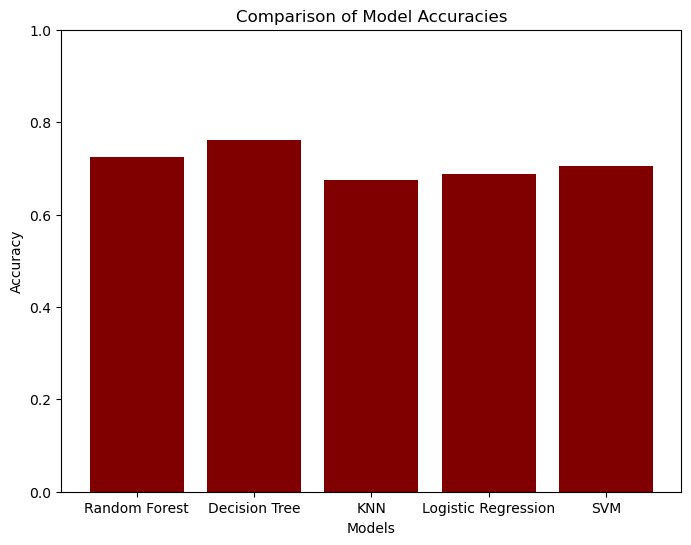

In [765]:
model_names = ['Random Forest', 'Decision Tree', 'KNN', 'Logistic Regression', 'SVM']
model_accuracies = [rf_accuracy, dt_accuracy,  knn_accuracy, lr_accuracy, svm_accuracy]  # Example values

# Bar chart for model comparison
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(model_names, model_accuracies, color='maroon')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracies')
plt.ylim(0, 1)  # Set y-axis from 0 to 1 to reflect accuracy percentages
plt.show()

<h2>Performance Tuning</h2>

<h3>Enhancing Accuracy for Random Forest Model</h3>

In [791]:
# Define the features (X) and target (y)
X = df_house_price_cleaned.drop(columns=['buying_decision'])  # Independent variables
y = df_house_price_cleaned['buying_decision']  # Target variable

# Encode the target variable if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Step 1: Hyperparameter Tuning for Random Forest ###
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_rf = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the tuned Random Forest
y_pred = best_rf.predict(X_test)
print("\nRandom Forest (Tuned) Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

### Step 2: Feature Selection with Lasso ###
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Identify important features
lasso_coef = pd.Series(lasso.coef_, index=df_house_price_cleaned.drop(columns=['buying_decision']).columns)
important_features = lasso_coef[lasso_coef != 0].index.tolist()
print("\nSelected Features by Lasso:", important_features)

# Train a Random Forest using selected features
X_train_selected = X_train[:, lasso_coef != 0]
X_test_selected = X_test[:, lasso_coef != 0]

best_rf_selected = RandomForestClassifier(random_state=42, **grid_search.best_params_)
best_rf_selected.fit(X_train_selected, y_train)

y_pred_selected = best_rf_selected.predict(X_test_selected)
print("\nRandom Forest (Lasso-Selected Features) Accuracy:", accuracy_score(y_test, y_pred_selected))

### Step 3: Dimensionality Reduction with PCA ###
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_pca = RandomForestClassifier(random_state=42, **grid_search.best_params_)
rf_pca.fit(X_train_pca, y_train)

y_pred_pca = rf_pca.predict(X_test_pca)
print("\nRandom Forest (PCA) Accuracy:", accuracy_score(y_test, y_pred_pca))

### Step 5: Cross-Validation for Model Evaluation ###
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=10, scoring='accuracy')
print("\nCross-Validation Accuracy for Random Forest:", np.mean(cv_scores))

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest (Tuned) Accuracy: 0.7560521415270018

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85      1462
           1       0.93      0.26      0.40       686

    accuracy                           0.76      2148
   macro avg       0.84      0.62      0.62      2148
weighted avg       0.80      0.76      0.70      2148


Selected Features by Lasso: ['property_scope', 'availability', 'location', 'bedroom', 'total_squarefeet', 'bath', 'balcony', 'BER', 'Renovation needed', 'price_per_squarefeet ($)', 'total_price ($)']

Random Forest (Lasso-Selected Features) Accuracy: 0.7593109869646183

Random Forest (PCA) Accuracy: 0.707169459962756

Cross-Validation Accuracy for Random Forest: 0.7572879949878601


<h3>Enhancing Accuracy for Decision Tree Model</h3>

In [793]:
# Define the features (X) and target (y)
X = df_house_price_cleaned.drop(columns=['buying_decision'])  # Drop the target variable
y = df_house_price_cleaned['buying_decision']  # Target variable

# Encode the target variable if it's categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Hyperparameter Tuning for Decision Tree
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

# Best Decision Tree Model
best_dt = grid_search_dt.best_estimator_
print("Best Hyperparameters for Decision Tree:", grid_search_dt.best_params_)

# Evaluate the tuned Decision Tree
y_pred_dt = best_dt.predict(X_test)
print("\nDecision Tree (Tuned) Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

# Cross-Validation for Decision Tree
cv_scores_dt = cross_val_score(best_dt, X_scaled, y, cv=10, scoring='accuracy')
print("\nCross-Validation Accuracy for Decision Tree:", cv_scores_dt.mean())

Best Hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Decision Tree (Tuned) Accuracy: 0.7611731843575419

Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1462
           1       0.99      0.25      0.40       686

    accuracy                           0.76      2148
   macro avg       0.87      0.63      0.63      2148
weighted avg       0.82      0.76      0.71      2148


Cross-Validation Accuracy for Decision Tree: 0.7563564624150253


<h3>Enhancing Accuracy for KNN</h3>

In [795]:
# # Hyperparameter Tuning for KNN
# param_grid = {
#     'n_neighbors': range(1, 21),
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan', 'minkowski']
# }

# knn = KNeighborsClassifier()
# grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search_knn.fit(X_train, y_train)

# # Best KNN Model
# best_knn = grid_search_knn.best_estimator_
# print("Best Hyperparameters for KNN:", grid_search_knn.best_params_)

# # Evaluate the tuned KNN
# y_pred_knn = best_knn.predict(X_test)
# print("\nKNN (Tuned) Accuracy:", accuracy_score(y_test, y_pred_knn))
# print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

# # Cross-Validation for KNN
# cv_scores_knn = cross_val_score(best_knn, X_scaled, y, cv=10, scoring='accuracy')
# print("\nCross-Validation Accuracy for KNN:", cv_scores_knn.mean())

<h3>Visualising accuracy improvements with performance tuning

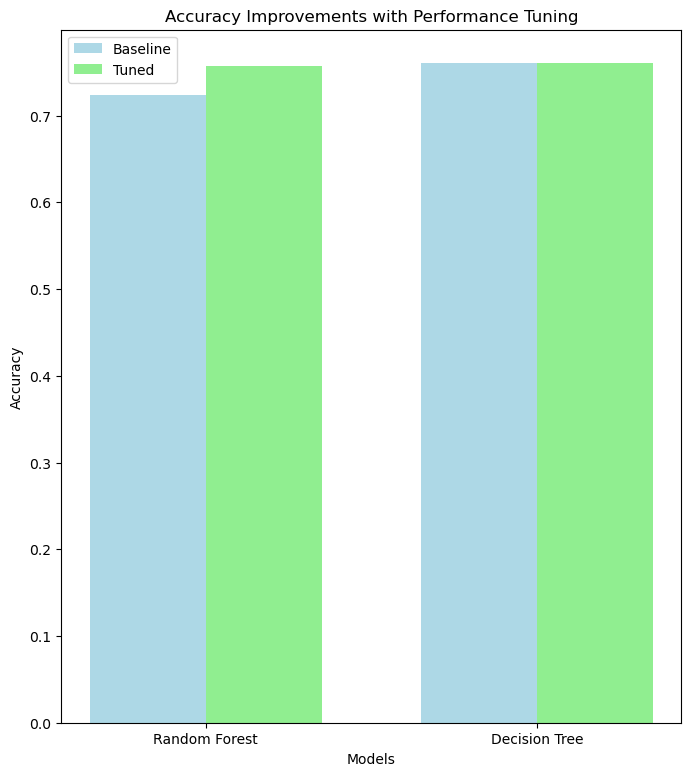

In [799]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'Decision Tree']

# Baseline accuracies (before tuning)
baseline_accuracies = [rf_accuracy, dt_accuracy]  # Example values

# Tuned accuracies (after tuning)
tuned_accuracies = [0.757, 0.761]  # Example values

# Bar chart
x = np.arange(len(models))  # Model index positions
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 9))
bar1 = ax.bar(x - width/2, baseline_accuracies, width, label='Baseline', color='lightblue')
bar2 = ax.bar(x + width/2, tuned_accuracies, width, label='Tuned', color='lightgreen')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Improvements with Performance Tuning')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()